In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tueplots import bundles, figsizes, axes

In [2]:
plt.rcParams['figure.dpi'] = 200

In [3]:
pt_to_inch_factor = 1 / 72
colinch = pt_to_inch_factor*235
figsize = {'figure.figsize': (colinch, pt_to_inch_factor*140)}
colinch / pt_to_inch_factor, 1.6 / pt_to_inch_factor

(235.0, 115.20000000000002)

# Synthetic Experiment

In [4]:
def leaf_dict_to_list(result):
    for k in result:
        for v in result[k]:
            for e in result[k][v]:
                if v == 'optimum':
                    result[k][v][e] = [result[k][v][e],]
                    continue
                for l in result[k][v][e]:
                    result[k][v][e][l] = [result[k][v][e][l],]
    return result

def append_dict_to_leafs(result, add_result):
    for k in result:
        for v in result[k]:
            for e in result[k][v]:
                if v == 'optimum':
                    result[k][v][e].append(add_result[k][v][e])
                    continue
                for l in result[k][v][e]:
                    result[k][v][e][l].append(add_result[k][v][e][l])
    return result

def leaf_list_to_array(result):
    for k in result:
        for v in result[k]:
            for e in result[k][v]:
                if v == 'optimum':
                    result[k][v][e] = np.array(result[k][v][e])
                    continue
                for l in result[k][v][e]:
                    result[k][v][e][l] = np.array(result[k][v][e][l])
    return result

In [5]:
blue = "#1b4079"
green = "#50723C"
purple = "#8C2155"
red = "#E6480F"
orange = "#FA9500"
colors = [blue, purple, green, red, orange]

In [6]:
fn_template_l = 'modes=3_bnoise=1.0'
fn_template_r = 'hetb=False_hetnoise=True'  
result = None
for file in os.listdir('../synthetic_results'):
    if fn_template_l in file and fn_template_r in file:
        if result is None:
            with open(f'../synthetic_results/{file}', 'rb') as f:
                result = leaf_dict_to_list(pickle.load(f))
        else:
            with open(f'../synthetic_results/{file}', 'rb') as f:
                result = append_dict_to_leafs(result, pickle.load(f))
result = leaf_list_to_array(result)
subset_sizes = sorted(list(result.keys()))
reps = len(result)

In [7]:
methods = ['optimum', 'pathfa', 'plier', 'mofa', 'multipathfa', 'fa']
method_names = ['Optimum', 'PathFA', 'PLIER', 'MOFA', 'Multi PathFA', 'FA']
names = {a: b for a, b, in zip(methods, method_names)}

## $\sigma_\textrm{prot}$ and $\sigma_\textrm{rna}$ reconstruction

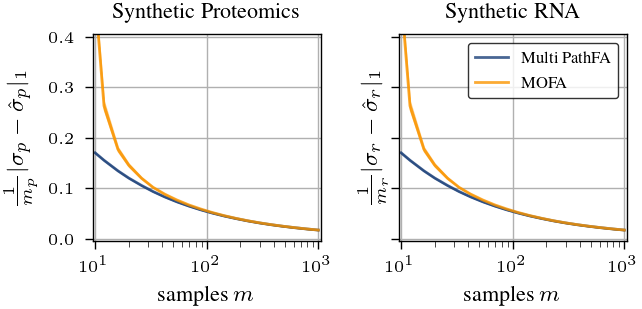

In [8]:
with plt.rc_context({**bundles.icml2022(column='half', usetex=True), **axes.lines(), 
                     **{'figure.figsize': (colinch, 1.6)}}):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
    ax = axs[0]
    ax.grid()
    methods = ['multipathfa', 'mofa']
    cs = [blue, orange, orange, red]
    perfm = {m: list() for m in methods}
    perfstde = {m: list() for m in methods}
    for k in subset_sizes:
        for m in perfm.keys():
            perfm[m].append(np.mean(result[k][m]['rna']['sigma_l1']))
            perfstde[m].append(np.std(result[k][m]['rna']['sigma_l1']) / np.sqrt(reps))
    for m, c in zip(perfm.keys(), cs):
        mu, stde = np.array(perfm[m]), np.array(perfstde[m])
        ax.plot(subset_sizes, mu, label=names[m], color=c, lw=1.0, alpha=0.8)
        ax.fill_between(subset_sizes, mu-2*stde, mu+2*stde, alpha=0.5, color=c)
    ax.set_xscale('log')
    ax.grid()
    ax.set_title('Synthetic Proteomics')
    ax.set_xlabel('samples $m$')
    ax.set_ylabel('$\\frac{1}{m_p} |\sigma_p - \hat{\sigma}_p|_1$')
    
    ax = axs[1]
    ax.grid()
    perfm = {m: list() for m in methods}
    perfstde = {m: list() for m in methods}
    for k in subset_sizes:
        for m in perfm.keys():
            perfm[m].append(np.mean(result[k][m]['rna']['sigma_l1']))
            perfstde[m].append(np.std(result[k][m]['rna']['sigma_l1']) / np.sqrt(reps))
    for m, c in zip(perfm.keys(), cs):
        mu, stde = np.array(perfm[m]), np.array(perfstde[m])
        ax.plot(subset_sizes, mu, label=names[m], color=c, lw=1, alpha=0.8)
        ax.fill_between(subset_sizes, mu-2*stde, mu+2*stde, alpha=0.5, color=c)
    ax.set_xscale('log')
    ax.legend()
    ax.set_ylabel('$\\frac{1}{m_r} |\sigma_r - \hat{\sigma}_r|_1$')
    ax.set_xlabel('samples $m$')
    ax.set_title('Synthetic RNA')
    ax.set_xlim([9.5, 10**3+50])
    ax.set_ylim([-0.005, 0.405])
    ax.grid()
    axs[0].grid()
    axs[1].grid()
    plt.savefig('../figures/sigmas.pdf')
    plt.show()

## Reconstruction on Test Data

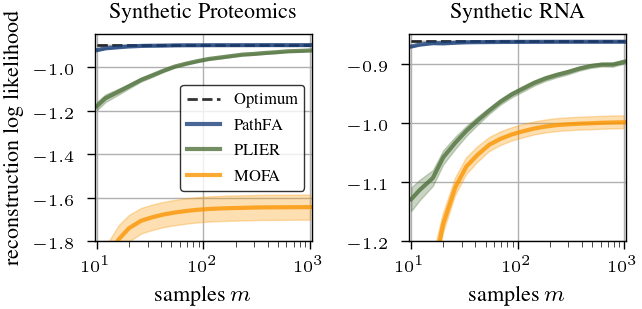

In [9]:
with plt.rc_context({**bundles.icml2022(column='half', usetex=True), **axes.lines(), 
                     **{'figure.figsize': (colinch, 1.6)}}):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=True)
    
    ax = axs[0]
    ax.grid()
    methods = ['optimum', 'pathfa', 'plier', 'mofa']
    cs = ['black', blue, green, orange]
    perfm = {m: list() for m in methods}
    perfstde = {m: list() for m in methods}
    for k in subset_sizes:
        for m in perfm.keys():
            if m == 'optimum':
                perfa = result[k][m]['prot']
            else:
                perfa = result[k][m]['prot']['nll']
            perfm[m].append(np.mean(perfa))
            perfstde[m].append(np.std(perfa) / np.sqrt(reps))
    for m, c in zip(perfm.keys(), cs):
        mu, stde = np.array(perfm[m]), np.array(perfstde[m])
        ax.plot(subset_sizes, mu, label=names[m], color=c, alpha=0.8,
                 lw=1 if c == 'black' else 1.5, ls='--' if c == 'black' else '-')
        ax.fill_between(subset_sizes, mu-stde, mu+stde, alpha=0.3, color=c)
    ax.set_xscale('log')
    ax.set_ylim([-1.8, -0.85])
    ax.set_title('Synthetic Proteomics')
    ax.set_ylabel('reconstruction log likelihood')
    ax.legend()
    ax.grid()
    
    ax = axs[1]
    ax.grid()
    cs = ['black', blue, green, orange]
    perfm = {m: list() for m in methods}
    perfstde = {m: list() for m in methods}
    for k in subset_sizes:
        for m in perfm.keys():
            if m == 'optimum':
                perfa = result[k][m]['rna']
            else:
                perfa = result[k][m]['rna']['nll']
            perfm[m].append(np.mean(perfa))
            perfstde[m].append(np.std(perfa) / np.sqrt(reps))
    for m, c in zip(perfm.keys(), cs):
        mu, stde = np.array(perfm[m]), np.array(perfstde[m])
        ax.plot(subset_sizes, mu, label=names[m], color=c, alpha=0.8,
                 lw=1 if c == 'black' else 1.5, ls='--' if c == 'black' else '-')
        ax.fill_between(subset_sizes, mu-stde, mu+stde, alpha=0.3, color=c)
    ax.set_xscale('log')
    ax.set_ylim([-1.2, -0.85])
    ax.set_title('Synthetic RNA')
    ax.set_xlim([9.5, 10**3+50])
    ax.set_xlabel('samples $m$')
    ax.grid()
    axs[0].grid()
    axs[1].grid()
    axs[0].set_xlabel('samples $m$')
    
    plt.savefig('../figures/reconstruction.pdf')
    plt.show()

## Joint vs. Marginal Reconstruction

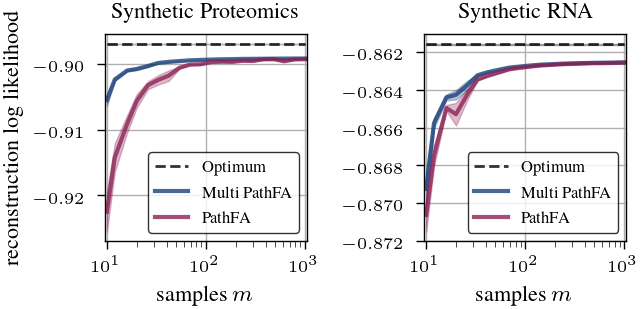

In [10]:
with plt.rc_context({**bundles.icml2022(column='half', usetex=True), **axes.lines(), 
                     **{'figure.figsize': (colinch, 1.6)}}):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=True)
    
    ax = axs[0]
    ax.grid()
    methods = ['optimum', 'multipathfa', 'pathfa']
    cs = ['black', blue, purple]
    perfm = {m: list() for m in methods}
    perfstde = {m: list() for m in methods}
    for k in subset_sizes:
        for m in perfm.keys():
            if m == 'optimum':
                perfa = result[k][m]['prot']
            else:
                perfa = result[k][m]['prot']['nll']
            perfm[m].append(np.mean(perfa))
            perfstde[m].append(np.std(perfa) / np.sqrt(reps))
    for m, c in zip(perfm.keys(), cs):
        mu, stde = np.array(perfm[m]), np.array(perfstde[m])
        ax.plot(subset_sizes, mu, label={**names, **{'bayplier': 'Prot PathFA'}}[m], color=c, alpha=0.8,
                 lw=1 if c == 'black' else 1.5, ls='--' if c == 'black' else '-')
        ax.fill_between(subset_sizes, mu-stde, mu+stde, alpha=0.3, color=c)
    ax.set_xscale('log')
    ax.set_title('Synthetic Proteomics')
    ax.set_ylabel('reconstruction log likelihood')
    ax.legend()
    ax.set_xlim([9.5, 10**3+50])
    ax.grid()
    
    ax = axs[1]
    ax.grid()
    methods = ['optimum', 'multipathfa', 'pathfa']
    cs = ['black', blue, purple]
    perfm = {m: list() for m in methods}
    perfstde = {m: list() for m in methods}
    for k in subset_sizes:
        for m in perfm.keys():
            if m == 'optimum':
                perfa = result[k][m]['rna']
            else:
                perfa = result[k][m]['rna']['nll']
            perfm[m].append(np.mean(perfa))
            perfstde[m].append(np.std(perfa) / np.sqrt(reps))
    for m, c in zip(perfm.keys(), cs):
        mu, stde = np.array(perfm[m]), np.array(perfstde[m])
        ax.plot(subset_sizes, mu, label={**names, **{'bayplier': 'RNA PathFA'}}[m], color=c, alpha=0.8,
                 lw=1 if c == 'black' else 1.5, ls='--' if c == 'black' else '-')
        ax.fill_between(subset_sizes, mu-stde, mu+stde, alpha=0.3, color=c)
    ax.legend()
    ax.set_xscale('log')
    ax.set_title('Synthetic RNA')
    ax.set_xlabel('samples $m$')
    ax.grid()
    ax.set_xlim([9.5, 10**3+50])
    axs[0].set_xlabel('samples $m$')
    axs[0].grid()
    axs[1].grid()
    
    plt.savefig('../figures/multimodal_reconstruction.pdf')
    plt.show()

# TuPro

In [8]:
import seaborn as sns

In [9]:
RES_DIR = '../tupro_results'
TUPRO_PATH = '..'  # put tupro path to relevant metdata

## Scatter plot heterogeneity vs. `MTORC1_SIGNALING` pathway

In [13]:
rna_flags = f'rpm_quantile_normalize_zscore'
prot_flags = f'rpm_quantile_normalize_zscore'
path = f'../tupro_results/ovarian/pathfa_msigdb-hallmark_latents=10_{rna_flags}_{prot_flags}/'
U = pd.read_csv(path + 'U.csv', index_col=0)
B = pd.read_csv(path + 'B.csv', index_col=0)
U.columns = U.columns.astype(int)
B.index = B.index.astype(int)
UB = (U @ B).T

In [17]:
heterogeneity = pd.read_csv(f'{TUPRO_PATH}/ovca-primary_neo_relapse-cytof-tumor-combined_clustering-all_measures.tsv', sep='\t', index_col=1)
heterogeneity = heterogeneity.loc[UB.index]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


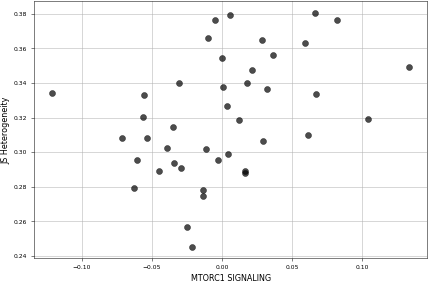

In [18]:
with plt.rc_context({**bundles.icml2022(column='half', usetex=True), **axes.lines(), 
                     **{'figure.figsize': (colinch, 1.8)}}):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
    ax.grid()
    ax.scatter(UB['HALLMARK_MTORC1_SIGNALING'], heterogeneity['jensenshannon'], c='black', alpha=0.7)
    ax.set_xlabel('MTORC1 SIGNALING')
    ax.set_ylabel('JS Heterogeneity')
    plt.savefig('../figures/heterogeneity_scatter.pdf')
    plt.show()

In [19]:
import scipy as sp

In [20]:
sp.stats.pearsonr(UB['HALLMARK_MTORC1_SIGNALING'], heterogeneity['jensenshannon'])

(0.4068541590102041, 0.00749719089861709)

In [30]:
sp.stats.pearsonr(UB['HALLMARK_MTORC1_SIGNALING'], heterogeneity['jensenshannon'])

PearsonRResult(statistic=0.40685415901020405, pvalue=0.007497190898617084)

## Barplot for heterogeneity correlation

In [11]:
perf = pd.read_csv('../tupro_results/ovarian-msigdb-hallmark_mean.csv', index_col=0)
perfsem = pd.read_csv('../tupro_results/ovarian-msigdb-hallmark_stderr.csv', index_col=0)
method_mapping = {
    'pathfa-multi': 'Path-FA Multi',
    'pathfa-prot': 'Path-FA Prot',
    'pathfa-rna': 'Path-FA RNA',
    'fa-prot': 'FA Prot',
    'fa-rna': 'FA RNA',
    'mofa-multi': 'MOFA',
    'plier-prot': 'PLIER Prot',
    'plier-rna': 'PLIER RNA'
}

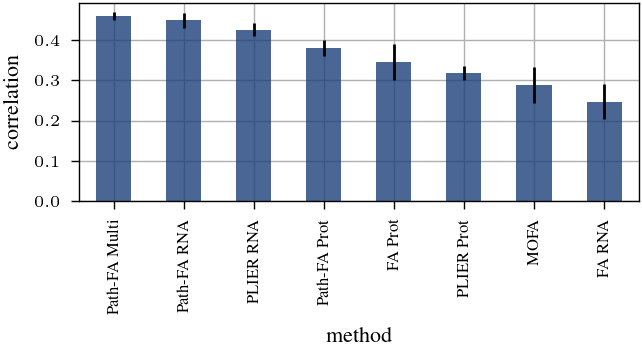

In [14]:
with plt.rc_context({**bundles.icml2022(column='half', usetex=True), **axes.lines(), 
                     **{'figure.figsize': (colinch, 1.8)}}):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
    perfjs = perf['jensenshannon'].rename(method_mapping).sort_values(ascending=False)
    semjs = perfsem.rename(method_mapping).loc[perfjs.index, 'jensenshannon']
    perfjs.plot.bar(
        ax=ax, color=blue, yerr=[semjs, semjs], alpha=0.8)
    ax.set_ylabel('correlation')
    ax.set_xlabel('method')
    ax.grid()
    plt.savefig('../figures/heterogeneity_pearson.pdf')
    plt.show()

## CYTOF Correlation Barplots

In [15]:
genesets = [
    'curated-melanoma-cell_type',
    'msigdb-c8.cell_type',
    'msigdb-hallmark',
]

In [16]:
tumor = 'melanoma'
pathways = 'msigdb-hallmark'
df = pd.read_csv(f'../tupro_results/{tumor}-{pathways}_raw.csv', index_col=0)
if 'jensenshannon' in df:
    del df['jensenshannon']

In [17]:
df = (df.set_index(['name', 'modality', 'method', 'seed'])
      .melt(ignore_index=False, var_name='setting')
      .reset_index())
df['method'] = df['method'].replace({'pathfa': 'Path FA', 'mofa': 'FA', 'plier': 'PLIER',
                                     'fa': 'FA', 'pathfa': 'Path FA'})
df = df.rename({'setting': 'type', 'value': 'correlation'}, axis=1)
mod_rename = {'multi': 'Multi', 'rna': 'RNA', 'prot': 'Prot'}
df['modality'] = df['modality'].apply(lambda x: mod_rename[x])

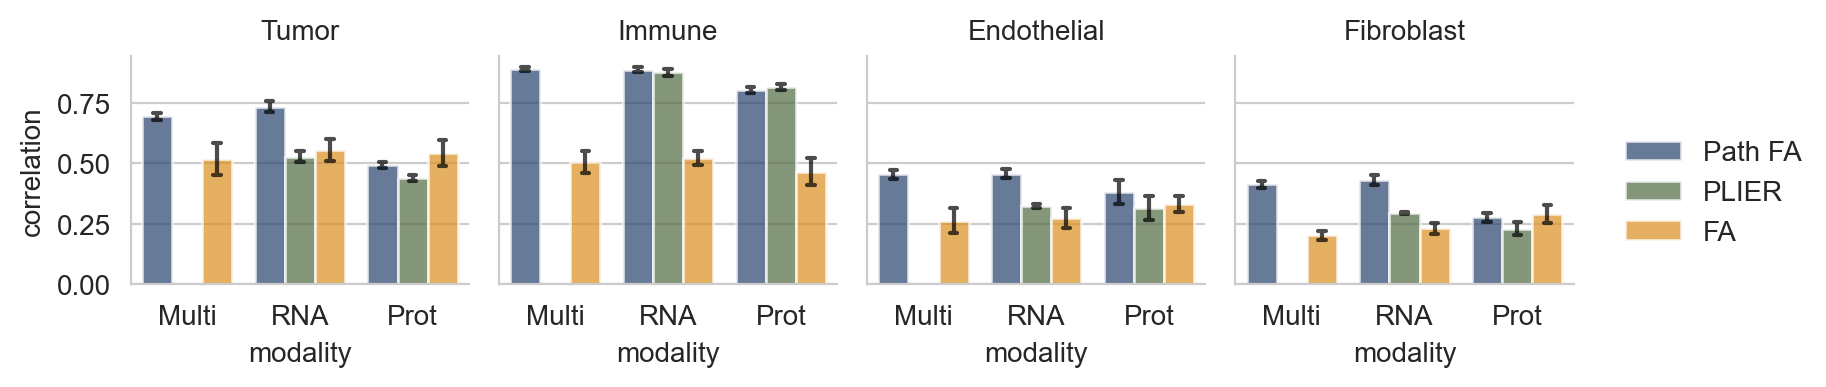

In [18]:
sns.set_style('whitegrid')
cmap = sns.color_palette([blue, green, orange])
g = sns.FacetGrid(df, col='type', height=colinch/1.6, aspect=1, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(
    sns.barplot,
    x='modality', y='correlation', hue='method',
    hue_order=['Path FA', 'PLIER', 'FA'],
    order=['Multi', 'RNA', 'Prot'],
    palette=cmap,
    errorbar=('se', 1),
    alpha=0.7,
    err_kws=dict(color='black', alpha=0.7, linewidth=1.5),
    capsize=0.2,
)
g.set_titles(col_template='{col_name}')
g.add_legend()
g.tight_layout()
g.savefig(f'../figures/{tumor}-{pathways}.pdf')
plt.show()